In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

from src.data.data_manager import create_data_loaders
from src.utils.config_manager import load_config

In [2]:
plt.rcParams['figure.figsize'] = (12, 6)

config = load_config('../../config/config.yaml')
mode = config['model'].get('type', 'regression')

if mode != 'regression':
    print("WARNING: Naive baselines use regression. Switching to regression mode.")

print(f"Configuration:")
print(f"  - Sample rate: {config['data']['sample_rate']}")
print(f"  - Slice length: {config['data']['slice_length']}s")
print(f"  - Test split: {config['data']['test_split']}")
print(f"  - Val split: {config['data']['val_split']}")

train_loader, val_loader, test_loader, dataset = create_data_loaders(config)

print(f"\nSet sizes:")
print(f"  - Train: {len(train_loader.dataset)} samples")
print(f"  - Val: {len(val_loader.dataset)} samples")
print(f"  - Test: {len(test_loader.dataset)} samples")

Configuration:
  - Sample rate: 48000
  - Slice length: 0.1s
  - Test split: 0.2
  - Val split: 0.2
Total samples: 1975
Total unique audio files: 333
Split results:
  Train files: 212 -> 1261 slices
  Val files: 54 -> 329 slices
  Test files: 67 -> 385 slices

Set sizes:
  - Train: 1261 samples
  - Val: 329 samples
  - Test: 385 samples


Label shapes:
  - Train: (1261,)
  - Val: (329,)
  - Test: (385,)

Statistics (train):
  - Min: 29.00°C
  - Max: 45.00°C
  - Mean: 37.22°C
  - Median: 37.50°C
  - Std: 4.57°C


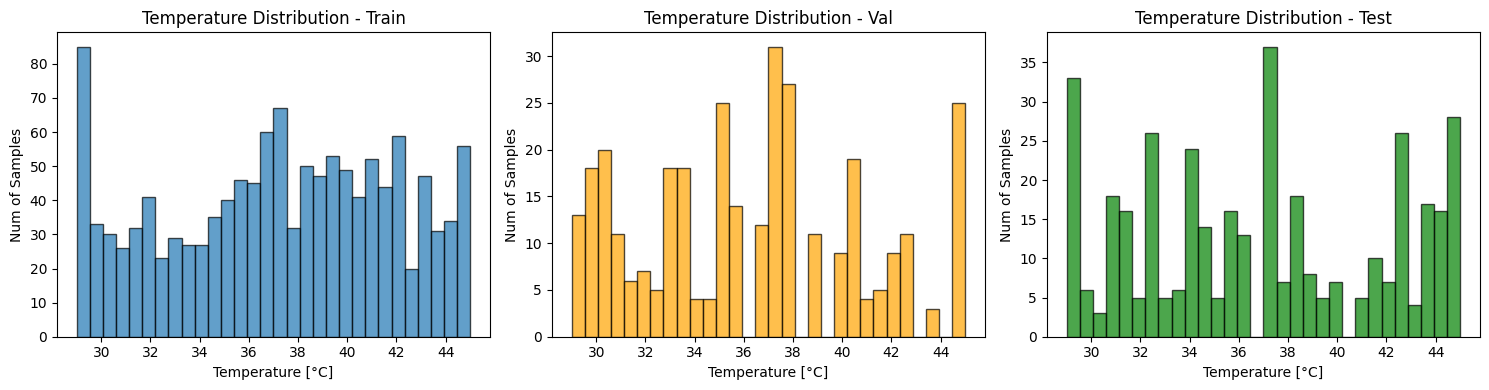

In [3]:
def extract_labels(data_loader):
    labels = []
    for _, label in data_loader:
        if isinstance(label, torch.Tensor):
            labels.extend(label.cpu().numpy())
        else:
            labels.extend(label)
    return np.array(labels)

y_train = extract_labels(train_loader)
y_val = extract_labels(val_loader)
y_test = extract_labels(test_loader)

print("Label shapes:")
print(f"  - Train: {y_train.shape}")
print(f"  - Val: {y_val.shape}")
print(f"  - Test: {y_test.shape}")

y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()
print(f"\nStatistics (train):")
print(f"  - Min: {y_train.min():.2f}°C")
print(f"  - Max: {y_train.max():.2f}°C")
print(f"  - Mean: {y_train.mean():.2f}°C")
print(f"  - Median: {np.median(y_train):.2f}°C")
print(f"  - Std: {y_train.std():.2f}°C")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_train, bins=30, alpha=0.7, edgecolor='black')
axes[0].set_title('Temperature Distribution - Train')
axes[0].set_xlabel('Temperature [°C]')
axes[0].set_ylabel('Num of Samples')
axes[1].hist(y_val, bins=30, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Temperature Distribution - Val')
axes[1].set_xlabel('Temperature [°C]')
axes[1].set_ylabel('Num of Samples')
axes[2].hist(y_test, bins=30, alpha=0.7, edgecolor='black', color='green')
axes[2].set_title('Temperature Distribution - Test')
axes[2].set_xlabel('Temperature [°C]')
axes[2].set_ylabel('Num of Samples')

plt.tight_layout()
plt.savefig('../../results/baselines/data_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [4]:
print("NAIVE BASELINES")
results = {}

mean_pred = np.full_like(y_test, y_train.mean())
results['Mean'] = {'MSE': mean_squared_error(y_test, mean_pred), 'MAE': mean_absolute_error(y_test, mean_pred), 'RMSE': np.sqrt(mean_squared_error(y_test, mean_pred)), 'R2': r2_score(y_test, mean_pred)}
median_pred = np.full_like(y_test, np.median(y_train))

results['Median'] = {'MSE': mean_squared_error(y_test, median_pred), 'MAE': mean_absolute_error(y_test, median_pred), 'RMSE': np.sqrt(mean_squared_error(y_test, median_pred)), 'R2': r2_score(y_test, median_pred)}

np.random.seed(42)
random_pred = np.random.choice(y_train, size=len(y_test))
results['Random'] = {'MSE': mean_squared_error(y_test, random_pred), 'MAE': mean_absolute_error(y_test, random_pred), 'RMSE': np.sqrt(mean_squared_error(y_test, random_pred)), 'R2': r2_score(y_test, random_pred)}

gaussian_pred = np.random.normal(y_train.mean(), y_train.std(), size=len(y_test))
results['Gaussian'] = {'MSE': mean_squared_error(y_test, gaussian_pred), 'MAE': mean_absolute_error(y_test, gaussian_pred), 'RMSE': np.sqrt(mean_squared_error(y_test, gaussian_pred)), 'R2': r2_score(y_test, gaussian_pred)}

results_df = pd.DataFrame(results).T
print("\n" + results_df.to_string())
print("\nBest model (MAE):", results_df['MAE'].idxmin())
print(f"Best MAE: {results_df['MAE'].min():.4f}°C")

NAIVE BASELINES

                MSE       MAE      RMSE        R2
Mean      24.756234  4.307102  4.975564 -0.005453
Median    25.040260  4.319481  5.004024 -0.016988
Random    43.151299  5.300000  6.568965 -0.752553
Gaussian  52.053918  5.890451  7.214840 -1.114125

Best model (MAE): Mean
Best MAE: 4.3071°C


In [ ]:
def extract_simple_features(data_loader):
    features_list = []
    labels_list = []
    for spectrograms, labels in data_loader:
        for spec, label in zip(spectrograms, labels):
            spec_np = spec.cpu().numpy()
            features = {
                'mean': np.mean(spec_np),
                'std': np.std(spec_np),
                'max': np.max(spec_np),
                'min': np.min(spec_np),
                'median': np.median(spec_np),
                'q25': np.percentile(spec_np, 25),
                'q75': np.percentile(spec_np, 75),
                'energy': np.sum(spec_np ** 2),
                'rms': np.sqrt(np.mean(spec_np ** 2)),
                'skewness': stats.skew(spec_np.flatten()),
                'kurtosis': stats.kurtosis(spec_np.flatten())}
            features_list.append(list(features.values()))
            labels_list.append(label.cpu().numpy() if isinstance(label, torch.Tensor) else label)
    return np.array(features_list), np.array(labels_list)

X_train, y_train_feat = extract_simple_features(train_loader)
X_val, y_val_feat = extract_simple_features(val_loader)
X_test, y_test_feat = extract_simple_features(test_loader)

y_train_feat = y_train_feat.flatten()
y_val_feat = y_val_feat.flatten()
y_test_feat = y_test_feat.flatten()

print("SIMPLE FEATURE EXTRACTION")
print(f"\nShape of fetaures:")
print(f"  - X_train: {X_train.shape}")
print(f"  - X_val: {X_val.shape}")
print(f"  - X_test: {X_test.shape}")
print(f"  - Number of features: {X_train.shape[1]}")

if mode == 'regression':
    print("\n" + "="*70)
    print("REGRESJA LINIOWA NA PROSTYCH CECHACH")
    print("="*70)
    lr = LinearRegression()
    lr.fit(X_train, y_train_feat)
    lr_pred_train = lr.predict(X_train)
    lr_pred_val = lr.predict(X_val)
    lr_pred_test = lr.predict(X_test)
    print("\nTrain:")
    print(f"  MSE:  {mean_squared_error(y_train_feat, lr_pred_train):.4f}")
    print(f"  MAE:  {mean_absolute_error(y_train_feat, lr_pred_train):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_train_feat, lr_pred_train)):.4f}")
    print(f"  R2:   {r2_score(y_train_feat, lr_pred_train):.4f}")
    print("\nValidation:")
    print(f"  MSE:  {mean_squared_error(y_val_feat, lr_pred_val):.4f}")
    print(f"  MAE:  {mean_absolute_error(y_val_feat, lr_pred_val):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_val_feat, lr_pred_val)):.4f}")
    print(f"  R2:   {r2_score(y_val_feat, lr_pred_val):.4f}")
    print("\nTest:")
    print(f"  MSE:  {mean_squared_error(y_test_feat, lr_pred_test):.4f}")
    print(f"  MAE:  {mean_absolute_error(y_test_feat, lr_pred_test):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_feat, lr_pred_test)):.4f}")
    print(f"  R2:   {r2_score(y_test_feat, lr_pred_test):.4f}")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].scatter(y_train_feat, lr_pred_train, alpha=0.5, s=10)
    axes[0].plot([y_train_feat.min(), y_train_feat.max()], [y_train_feat.min(), y_train_feat.max()], 'r--', lw=2)
    axes[0].set_xlabel('Rzeczywista temperatura [°C]')
    axes[0].set_ylabel('Przewidziana temperatura [°C]')
    axes[0].set_title('Train Set')
    axes[0].grid(True, alpha=0.3)
    axes[1].scatter(y_val_feat, lr_pred_val, alpha=0.5, s=10, color='orange')
    axes[1].plot([y_val_feat.min(), y_val_feat.max()], [y_val_feat.min(), y_val_feat.max()], 'r--', lw=2)
    axes[1].set_xlabel('Rzeczywista temperatura [°C]')
    axes[1].set_ylabel('Przewidziana temperatura [°C]')
    axes[1].set_title('Validation Set')
    axes[1].grid(True, alpha=0.3)
    axes[2].scatter(y_test_feat, lr_pred_test, alpha=0.5, s=10, color='green')
    axes[2].plot([y_test_feat.min(), y_test_feat.max()], [y_test_feat.min(), y_test_feat.max()], 'r--', lw=2)
    axes[2].set_xlabel('Rzeczywista temperatura [°C]')
    axes[2].set_ylabel('Przewidziana temperatura [°C]')
    axes[2].set_title('Test Set')
    axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../../results/baselines/linear_regression_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    feature_names = ['mean', 'std', 'max', 'min', 'median', 'q25', 'q75', 'energy', 'rms', 'skewness', 'kurtosis']
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, lr.coef_)
    plt.xlabel('Współczynnik')
    plt.title('Ważność cech w Regresji Liniowej')
    plt.tight_layout()
    plt.savefig('../../results/baselines/feature_importance_lr.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
print("KNN REGRESSOR - VARIOUS K VALUES")
k_values = [1, 3, 5, 7, 10, 15, 20]
knn_results = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train_feat)
    pred_test = knn.predict(X_test)
    knn_results.append({'k': k, 'MSE': mean_squared_error(y_test_feat, pred_test), 'MAE': mean_absolute_error(y_test_feat, pred_test), 'RMSE': np.sqrt(mean_squared_error(y_test_feat, pred_test)), 'R2': r2_score(y_test_feat, pred_test)})
knn_df = pd.DataFrame(knn_results)
print("\n" + knn_df.to_string(index=False))
best_k = knn_df.loc[knn_df['MAE'].idxmin(), 'k']
print(f"\nBest k (MAE): {int(best_k)}")
print(f"Best MAE: {knn_df['MAE'].min():.4f}°C")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(knn_df['k'], knn_df['MAE'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('k (num of neighbors)')
axes[0].set_ylabel('MAE [°C]')
axes[0].set_title('MAE vs. k')
axes[0].grid(True, alpha=0.3)
axes[1].plot(knn_df['k'], knn_df['R2'], marker='o', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('k (num of neighbors)')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² vs. k')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../results/baselines/knn_k_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
best_knn = KNeighborsRegressor(n_neighbors=int(best_k))
best_knn.fit(X_train, y_train_feat)
knn_pred_test = best_knn.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_feat, knn_pred_test, alpha=0.5, s=10)
plt.plot([y_test_feat.min(), y_test_feat.max()], [y_test_feat.min(), y_test_feat.max()], 'r--', lw=2)
plt.xlabel('Real temperature [°C]')
plt.ylabel('Predicted temperature [°C]')
plt.title(f'KNN (k={int(best_k)}) - Test Set')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../results/baselines/knn_best_predictions.png', dpi=150, bbox_inches='tight')
plt.show()


SUMMARY

            Model      MAE     RMSE        R2
Linear Regression 3.823838 4.408818  0.210556
       KNN (k=20) 4.212143 4.941720  0.008179
             Mean 4.307102 4.975564 -0.005453
           Median 4.319481 5.004024 -0.016988
           Random 5.300000 6.568965 -0.752553
         Gaussian 5.890451 7.214840 -1.114125

 BEST MODEL: Linear Regression
   MAE: 3.8238°C
   RMSE: 4.4088°C
   R²: 0.2106


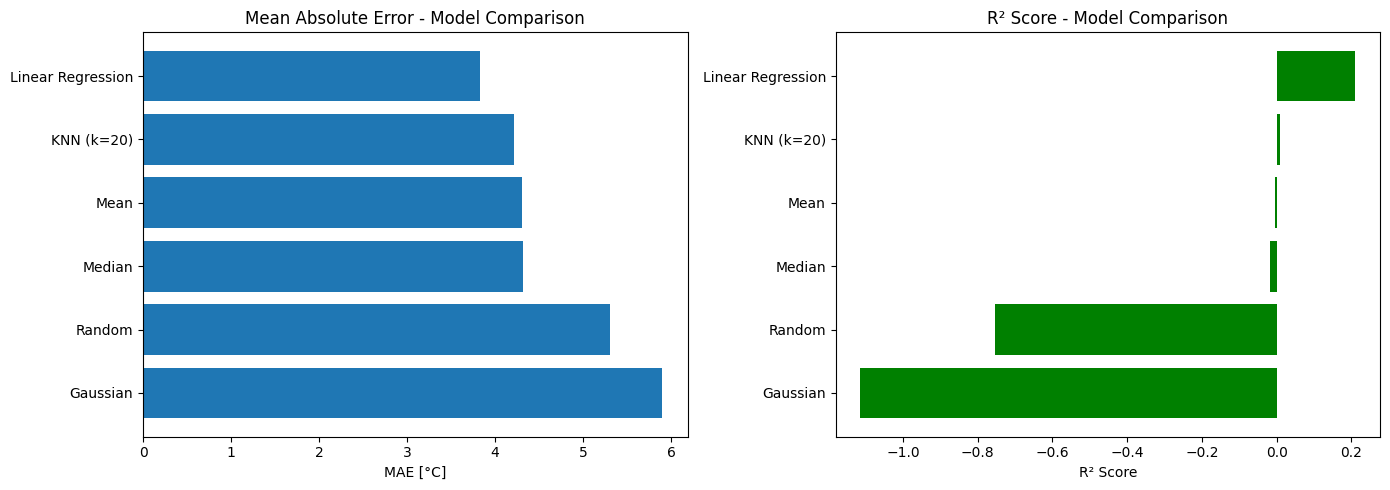

In [7]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
summary = pd.DataFrame({'Model': ['Mean', 'Median', 'Random', 'Gaussian', 'Linear Regression', f'KNN (k={int(best_k)})'], 'MAE': [results['Mean']['MAE'], results['Median']['MAE'], results['Random']['MAE'], results['Gaussian']['MAE'], mean_absolute_error(y_test_feat, lr_pred_test), knn_df.loc[knn_df['MAE'].idxmin(), 'MAE']], 'RMSE': [results['Mean']['RMSE'], results['Median']['RMSE'], results['Random']['RMSE'], results['Gaussian']['RMSE'], np.sqrt(mean_squared_error(y_test_feat, lr_pred_test)), knn_df.loc[knn_df['MAE'].idxmin(), 'RMSE']], 'R2': [results['Mean']['R2'], results['Median']['R2'], results['Random']['R2'], results['Gaussian']['R2'], r2_score(y_test_feat, lr_pred_test), knn_df.loc[knn_df['MAE'].idxmin(), 'R2']]})
summary = summary.sort_values('MAE')
print("\n" + summary.to_string(index=False))
print(f"\n BEST MODEL: {summary.iloc[0]['Model']}")
print(f"   MAE: {summary.iloc[0]['MAE']:.4f}°C")
print(f"   RMSE: {summary.iloc[0]['RMSE']:.4f}°C")
print(f"   R²: {summary.iloc[0]['R2']:.4f}")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].barh(summary['Model'], summary['MAE'])
axes[0].set_xlabel('MAE [°C]')
axes[0].set_title('Mean Absolute Error - Model Comparison')
axes[0].invert_yaxis()
axes[1].barh(summary['Model'], summary['R2'], color='green')
axes[1].set_xlabel('R² Score')
axes[1].set_title('R² Score - Model Comparison')
axes[1].invert_yaxis()
plt.tight_layout()
plt.savefig('../../results/baselines/baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
summary.to_csv('../../results/baselines/baseline_results_regression.csv', index=False)